# Deep Convolutional Generative Adversarial Network for the CIFAR-10 dataset

## What are GANS?

In the context of training Generative Adversarial Networks (GANs), the generator's loss function aims to minimize the difference between the generated samples and the real samples.

Two models are trained simultaneously by an adversarial process. A generator model learns to create images that look real, while a discriminator model learns to distinguish the real and generated images.

## What is the purpose?
At the end of training, the generator becomes better at generating images that look much realistic, and the discrimnator becomes stronger to detect the fake images.


The objective of this experiment was to train a Generative Adversarial Network (GAN) to generate realistic images from random noise.

This notebook demonstrates this process on the cifar10 dataset.

## Imoprt Necessary Libraries

In [ ]:
!pip install --upgrade keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 16.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import keras_cv
import matplotlib.pyplot as plt
from IPython import display
import time

## Load and prepare the dataset

You will use the cifar10 dataset to train the generator and the discriminator. We convert images the grayscale to reduce the computiational power and training time.



In [ ]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
to_grayscale = keras_cv.layers.Grayscale()
train_images = to_grayscale(train_images)


170498071/170498071 [==============================] - 2s 0us/step


### Normalize the images to [-1, 1]

In [ ]:
train_images = train_images.numpy().reshape(train_images.shape[0], 32, 32, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [ ]:
train_images[0].shape

(32, 32, 1)

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

### The Generator

The generator was designed as a sequential model with several dense and convolutional layers, followed by batch normalization and activation functions.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 1)

    return model

generator_model = make_generator_model()
generator_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (Batch  (None, 16384)             65536     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 8, 8, 128)         5

Use the untrained generator to create an image from random noises.

#### Why do generator need random noise?

Random noise serves as the input of generator model.

- Variability: Since the generator starts with random noise as input, it can produce a wide range of outputs, leading to diverse and realistic-looking images.
- Generalization: By training the generator on random noise, the GAN learns to generalize patterns present in the training data. This helps the generator to produce realistic samples even for data points it hasn't seen before.

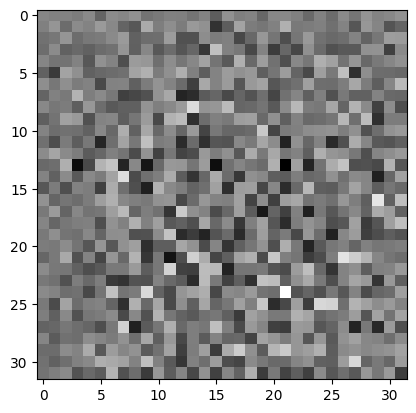

In [ ]:
noise = tf.random.normal([1, 100])

generated_image = generator_model(noise, training=False)
generated_image.shape
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator
The discriminator is a CNN-based image classifier.



In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=(32, 32, 1)))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

discriminator_model = make_discriminator_model()

In [ ]:
discriminator_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

## Define the loss and optimizers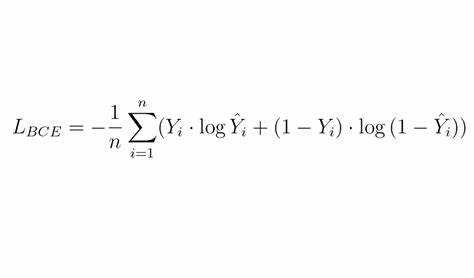

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Optimizer

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Discriminator loss
This method quatifies how well the discriminator is able to distinguish real images from fakes. We label the real images with 1 and fake images with 0.

In [ ]:
def discriminator_loss(real_images, fake_images):
  loss_for_real_images = cross_entropy(tf.ones_like(real_images), real_images);
  loss_for_fake_images = cross_entropy(tf.zeros_like(fake_images), fake_images);

  return loss_for_real_images + loss_for_fake_images

### Generator loss

This method quatifies how well the generator creates more realistic pictures, in other word how well it tricks the discrimnator. If the dicriminator label the generated picture as one (which means real), it is a good news for the generator.

In [ ]:
def generator_loss(fake_images):
  loss_for_fake_images = cross_entropy(tf.ones_like(fake_images), fake_images);

  return loss_for_fake_images

In [ ]:
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

###Training Loop


The `train_step` function is responsible for training both the generator and the discriminator of the Deep Convolutional Generative Adversarial Network. We are going to answer **how the generator is motivated to generate better pictures**

1. **Generating Fake Images**: In the `train_step` function, the generator is fed with random noise (`noise`) to produce fake/generated images (`generated_images`). These generated images are then passed to the discriminator for evaluation.

2. **Discriminator Feedback**: The discriminator evaluates both real images (`images`) from the dataset and the generated images (`generated_images`). It assigns probabilities (real or fake) to each image.

3. **Loss Calculation**: Based on the discriminator's evaluation, loss functions (`gen_loss` and `disc_loss`) are calculated for both the generator and the discriminator. These loss functions quantify how well the generator and discriminator are performing their respective tasks.

4. **Backpropagation and Gradient Descent**: Using the calculated loss values, gradients of the loss functions with respect to the trainable variables (weights and biases) of both the generator and the discriminator are computed using backpropagation. These gradients indicate the direction and magnitude of adjustments needed to minimize the loss functions.

5. **Optimizer Updates**: The gradients are then used to update the trainable variables of both the generator and the discriminator using optimization algorithms (e.g., Adam optimizer). This process aims to adjust the model parameters in a way that reduces the loss functions, effectively improving the performance of both the generator and the discriminator.

6. **Training Loop**: The `train` function iterates over the dataset for a specified number of epochs, calling the `train_step` function to update the model parameters in each epoch. Additionally, it periodically generates sample images and saves the model checkpoints for evaluation and future use.





In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator_model(noise, training=True)

      real_output = discriminator_model(images, training=True)
      fake_output = discriminator_model(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator_model,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator_model,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

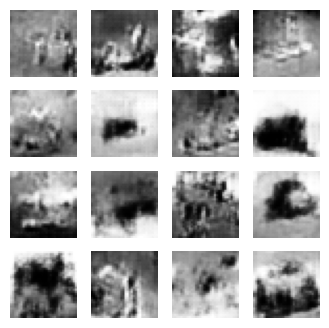

In [ ]:
train(train_dataset, EPOCHS)

## **Superiority of Gradient Ascent over Gradient Descent:**

When training Generative Adversarial Networks (GANs), the primary goal of the generator is to generate realistic images that can fool the discriminator. The generator's objective function typically involves minimizing a loss function, such as the Binary Cross-Entropy (BCE) loss, which measures the difference between the generated images and real images.


Gradient ascent advantages over gradient descent for optimizing the generator's objective function:

1. **Mode Collapse Mitigation:** Gradient ascent encourages the generator to explore different modes of the data distribution, thus mitigating the risk of mode collapse, where the generator produces limited varieties of samples.
2. **Improved Training Stability:** By maximizing a different loss function, gradient ascent can lead to more stable training dynamics, reducing the likelihood of the generator overpowering the discriminator or vice versa.
3. **Diverse Sample Generation:** Gradient ascent encourages the generator to produce more diverse and realistic samples by exploring different regions of the data distribution.

Let's consider an example.

Suppose we're training a GAN to generate images of handwritten digits. Using gradient ascent, the generator learns to generate a diverse set of digit images that closely resemble the distribution of real digit images. In contrast, gradient descent might lead the generator to produce a limited set of digit images, such as only generating the digit '7'.